# Assessing the benefit of growing a decision tree to post-process rainfall

# 1. Introduction

Research questions n. 1 (RQ1): are multiple-WT ecPoint-Rainfall forecasts better than the single-WT forecasts? 

Research questions n. 2 (RQ2): if so, is there a limit on the number of WTs that can contribute to a significant improvement of the ecPoint-Rainfall forecasts? 

# 2. Data

# 3. Methods & Results

Calibration and discrimination abilities are two of the key attributes of a probabilistic forecast (Murphy, 1991). Calibration deals with the meaning of probabilities in the forecast. Discrimination is the ability to distinguish between event and non-event, appraising the existance of a signal in the forecast when an event materialises and its absence when it does not. In this study, calibration is verified using the reliability component of the Brier score, while discrimination is verified using the ROC curve and the area under the ROC curve. Both scores will be computed for single-WT and multiple-WT ecPoint-Rainfall forecasts and raw ECMWF ENS that will be considered as a baseline performance. 

## 3.1 ROC and Area under the ROC (AURC)

The ROC curve plots the hit rate (HR) versus the false alarm rate (FAR) of an event for incremental decision threshold. A ROC curve is defined by the line joining successive ROC points, where each point corresponds to results for increasing decision threshold, from the top right to the bottom left corner of the unit square. The decision variable is the number of members exceeding the event-threshold (interpreted as a raw probability forecast), so the issued forecast takes values in [0, 1/M, 2/M, ..., M/M=1] for an ensemble of size M. As a consequence, the resulting ROC curve is based on up (M+1) points. The ROC curve is then completed by adding the points (0,0) and (1,1). The AURC is then estimated by the sum of the trapeziums formed by conneting with straight lines the (M+1) ROC points, including the (0,0) and (1,1) points. Therefore, this estimation of the AURC is known as the "trapezoidal approximation" (T-AURC). For rare events, there is a tendency for the points on the ROC to cluster towards the lower left corner of the unit square (Casati et al., 2008). When computing T-AURC, a straight line is drawn between the last meaningful point on the ROC curve and the top-raight corner to close the ROC curve, giving the impression that part of the curve is missing. How much of the curve is missing depends on the lowest category, defined here by the ensemble size and the base-rate of the event.

In order to draw a "full" ROC curve, one can fit the ROC curve with different models proposed in the literature, e.g. binormal model (Harvey et al., 1992; Wilson, 2000; Atger, 2004) or the most recent two-parameter beta family (Gneiting and Vogel, 2021) or the method that uses the mean of the probabilistic forecasts to complete the ROC (Bouallegue and Richardson, 2021). In this study, the binormal model will be used. The binormal model is based on the assumption that HR and FAR are integrations of a unit normal Gaussian distribution, and the AURC (denoted hear as Z-AURC) is computed using equations (2) and (3) in Harvey et al, 1992. When applied to ensemble-derived probability forecasts for rare events, this approach consists effectively in an extrapolation to a hypothetical continuous decision variable based on the limited set of decision thresholds materially assessable (Bouallegue and Richardson, 2021). because such a decision variable may not be achievable in practice, Z-AURC is sometimes considered as a measure of the potential discrimination ability that could be achieved for an "unlimited ensemble size" (Bowler et al., 2006).

T-AURC and Z-AURC summary metrics can provide very different comparative results, with typically T-AURC being smaller for rare events as ROC points tend to cluster on the bottom-left corner of the unit square. Therefore, T-AURC statistics point towards a larger predictive skill of the low event-thresholds probability forecasts, which the consequence of thinking that users would practically benefit more from using the lower event-threshold. The use of one or the other depends on the research question at hand, and in particular on whether the practical usefulness or the intrinsic information content of the ensemble forecast is the key aspect to be assessed. In this study, both aspects are of interest. Therefore, both T-AURC and Z-AURC will be estimated to assess the "real" and the "potential" dsicrimination ability of the single-WT and multiple-WT ecPoint-Rainfall forecasts. 

#### _CODE_

In [1]:
# REQUIRED PYTHON LIBRARIES
import os as os
import numpy as np
import metview as mv
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import r2_score

# INPUT PARAMETERS
BaseDateS = date(2020,10,1)
BaseDateF = date(2021,9,30)
BaseTime = 0
StepF = 30
Acc = 12
Thr = 50.0
#SystemFC_list = ["ENS", "ecPoint_Multiple_WT"]
SystemFC_list = ["ENS", "ecPoint_Multiple_WT", "ecPoint_Single_WT"]
GitRepo = "/vol/ecpoint/mofp/PhD/Papers2Write/ecPoint_Single_WT"
DirIN_CT = "Data/Processed/CT"
DirOUT_ROC = "Data/Processed/ROC"
#####################################################################################################################

############################
# COSTUME PYTHON FUNCTIONS #
############################

# Computation of 'real' Hit Rates (HR) and False Alarm Rates (FAR)
def HR_FAR(H,M,FA,CN):
    
    HR = H / (H + M)
    FAR = FA / (FA + CN)
    HR = np.insert(HR,0,1) #to make sure the ROC curve includes the point (0,0)
    FAR = np.insert(FAR,0,1)
    HR = np.append(HR,0) #to make sure the ROC curve includes the point (1.1)
    FAR = np.append(FAR,0)
    
    n = len(HR)
    AURC = 0
    for i in range(0,n-1):
        j = i + 1 
        a = HR[i]
        b = HR[j]
        h = FAR[j] - FAR[i]
        AURC = AURC + (((a+b)*h)/2)*(-1)
        
    return HR, FAR, AURC
        
# Computation of hit rates (HRz) and false alarm rates (FARz) from the binormal model
def binormal_HR_FAR(HR,FAR):
    
    HRz_inv = norm.ppf(HR) # z-score for HR
    FARz_inv = norm.ppf(FAR) # z-score for FAR
    ind_finite = np.where(np.isfinite(FARz_inv + HRz_inv)) # index only finite values
    HRz_inv = HRz_inv[ind_finite[0]]
    FARz_inv = FARz_inv[ind_finite[0]]

    binormal_params = np.polyfit(FARz_inv,HRz_inv,1) # apply linear regression (1) to define the parameters of the 
                                                     # binormal model.
        
    x = np.arange(-10,10,0.1) # sample the z-space
    predict = np.poly1d(binormal_params)
    y = predict(x)
    HRz = norm.cdf(y)
    FARz = norm.cdf(x)
    
    x_LR = FARz_inv
    y_LR = predict(x_LR)
    r2 = r2_score(HRz_inv,y_LR)
    
    AURCz = norm.cdf( (binormal_params[1]*( (binormal_params[0]**2+1.)/2.)**(-0.5) )/(2.**(0.5)))
    
    return HRz_inv, FARz_inv, x_LR, y_LR, r2, HRz, FARz, AURCz 


##############################
# SETTING GENERAL PARAMETERS #
##############################

# Setting parameters related to the considered verification period and the considered threshold
BaseDateSSTR = BaseDateS.strftime("%Y%m%d")
BaseDateFSTR = BaseDateF.strftime("%Y%m%d")
BaseTimeSTR = f'{BaseTime:02d}'
StepFSTR = f'{StepF:03d}'
AccSTR = f'{Acc:03d}'
ThrSTR = str(Thr)

# Setting sub-directories
DirIN_CT_temp = GitRepo + "/" + DirIN_CT + "_" + AccSTR + "_" + BaseDateSSTR + "_" + BaseDateFSTR + "_" + BaseTimeSTR + "/" + StepFSTR + "_" + ThrSTR
DirOUT_ROC_temp = GitRepo + "/" + DirOUT_ROC + "_" + AccSTR + "_" + BaseDateSSTR + "_" + BaseDateFSTR + "_" + BaseTimeSTR + "/" + StepFSTR + "_" + ThrSTR

#### _TEST FOR THE GOODNESS OF FIT OF BINORMAL MODEL FOR FITTING THE (REAL) ROC CURVES_

The binormal model is based on the assumption that HR and FAR are integrations of a unit normal Gaussian distribution. Because the model assumes that the two probability density functions (i.e. for HR and FAR) are Gaussian, when the HR and the FAR probabilities are converted to z-score (i.e. HR_inv and FAR_inv) deviations under the unit normal Gaussian distribution, the ROC becomes a straight line (Harvery et al., 1992, pp. 868). Therefore, the degree to which actual data lie along a straight line in z-score coordinates is a test of the model's validity (Harvery et al., 1992, pp. 868). In this study, the coefficient of determination, r2, is used. It determines the proportion of the variation in the dependent variable that is predictable from the independent variable, and it ranges from 0 (i.e., the model does not explain any of the variation in the dependent variable) to 1 (i.e., the model explains all the variation in the dependent variable).


 
Loading contingency table for ENS for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Testing the goodness of fit of the binormal model
 
Loading contingency table for ecPoint_Multiple_WT for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Testing the goodness of fit of the binormal model
 
Loading contingency table for ecPoint_Single_WT for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Testing the goodness of fit of the binormal model


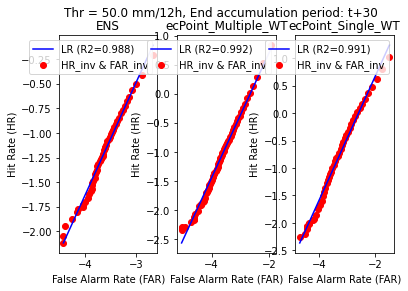

In [2]:
####################################################################
# TESTING GOODNESS OF FIT OF BINORMAL MODEL FOR FITTING ROC CURVES #
####################################################################

for SystemFC in SystemFC_list:
    
    Legend_gf = []
    
    # Setting parameters related to the considered forecasting system
    if SystemFC == "ENS":
        SystemFC_subplot = 131
    elif SystemFC == "ecPoint_Multiple_WT":
        SystemFC_subplot = 132
    elif SystemFC == "ecPoint_Single_WT":
        SystemFC_subplot = 133

    # Setting input files
    FileOUT_H = DirIN_CT_temp + "/H_" + SystemFC + ".npy"
    FileOUT_M = DirIN_CT_temp + "/M_" + SystemFC + ".npy"
    FileOUT_FA = DirIN_CT_temp + "/FA_" + SystemFC + ".npy"
    FileOUT_CN = DirIN_CT_temp + "/CN_" + SystemFC + ".npy"

    # Loading contingency tables
    print(" ")
    print("Loading contingency table for " + SystemFC + " for (t+" + str(StepF) + ") and Thr=" + str(Thr) + "mm/" + str(Acc) + "h")
    H = np.load(FileOUT_H)
    M = np.load(FileOUT_M)
    FA = np.load(FileOUT_FA)
    CN = np.load(FileOUT_CN)
                
    # Computing hit rates (HR) and false alarm rates (FAR)
    print("Computing 'real' ROC curve")
    HR, FAR, AURC = HR_FAR(H,M,FA,CN)
    
    # Testing the goodness of fit of the binormal model
    print("Testing the goodness of fit of the binormal model")
    HRz_inv, FARz_inv, x_LR, y_LR, r2, HRz, FARz, AURCz = binormal_HR_FAR(HR,FAR)
    
    plt.subplot(SystemFC_subplot)
    plt.scatter(FARz_inv, HRz_inv, color="r")
    plt.plot(x_LR, y_LR, "-b")
    
    Legend_gf.append("LR (R2=" + str(round(r2,3)) + ")")   
    Legend_gf.append("HR_inv & FAR_inv")
    
    plt.title(SystemFC)
    plt.xlabel('False Alarm Rate (FAR)')
    plt.ylabel('Hit Rate (HR)')
    plt.legend(Legend_gf)
    plt.rcParams["figure.figsize"] = (10,5)

plt.suptitle("Thr = " + str(Thr) + " mm/" + str(Acc) + "h, End accumulation period: t+" + str(StepF))
plt.show()

#### _ROC CURVES_

 
Loading contingency table for ENS for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Computing 'binormal' ROC curve
Plotting 'real' and 'binormal' ROC curves
 
Loading contingency table for ecPoint_Multiple_WT for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Computing 'binormal' ROC curve
Plotting 'real' and 'binormal' ROC curves
 
Loading contingency table for ecPoint_Single_WT for (t+30) and Thr=50.0mm/12h
Computing 'real' ROC curve
Computing 'binormal' ROC curve
Plotting 'real' and 'binormal' ROC curves


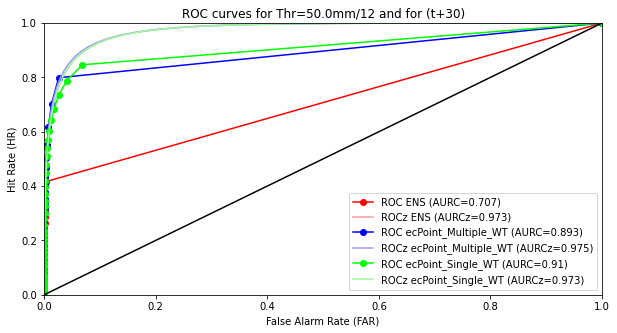

In [3]:
#######################
# PLOTTING ROC CURVES #
#######################

Legend = []

for SystemFC in SystemFC_list:
    
    # Setting parameters related to the considered forecasting system
    if SystemFC == "ENS":
        NumEM = 51
        Plot_real_ROC = [1,0,0]
        Plot_binormal_ROC = [1,0.6,0.6]
    elif SystemFC == "ecPoint_Multiple_WT":
        NumEM = 99
        Plot_real_ROC = [0,0,1]
        Plot_binormal_ROC = [0.6,0.6,1]
    elif SystemFC == "ecPoint_Single_WT":
        NumEM = 99
        Plot_real_ROC = [0,1,0]
        Plot_binormal_ROC = [0.6,1,0.6]

    # Setting input files
    FileOUT_H = DirIN_CT_temp + "/H_" + SystemFC + ".npy"
    FileOUT_M = DirIN_CT_temp + "/M_" + SystemFC + ".npy"
    FileOUT_FA = DirIN_CT_temp + "/FA_" + SystemFC + ".npy"
    FileOUT_CN = DirIN_CT_temp + "/CN_" + SystemFC + ".npy"

    # Loading contingency tables
    print(" ")
    print("Loading contingency table for " + SystemFC + " for (t+" + str(StepF) + ") and Thr=" + str(Thr) + "mm/" + str(Acc) + "h")
    H = np.load(FileOUT_H)
    M = np.load(FileOUT_M)
    FA = np.load(FileOUT_FA)
    CN = np.load(FileOUT_CN)
                
    # Computing hit rates (HR) and false alarm rates (FAR)
    print("Computing 'real' ROC curve")
    HR, FAR, AURC = HR_FAR(H,M,FA,CN)
    
    print("Computing 'binormal' ROC curve")
    _, _, _, _, _, HRz, FARz, AURCz  = binormal_HR_FAR(HR,FAR)
    
    # Plotting 'real' and 'binormal' ROC curves
    print("Plotting 'real' and 'binormal' ROC curves")
    plt.plot(FAR, HR, "-o", color=Plot_real_ROC)
    plt.plot(FARz, HRz, "-", color=Plot_binormal_ROC)
    Legend.append("ROC " + SystemFC + " (AURC=" + str(round(AURC,3)) + ")")
    Legend.append("ROCz " + SystemFC + " (AURCz=" + str(round(AURCz,3)) + ")")
    
dgn_x = np.zeros(2)
dgn_y = np.zeros(2)
dgn_x[1] = 1
dgn_y[1] = 1
plt.plot(dgn_x, dgn_y, "-k")
plt.title("ROC curves for Thr=" + str(Thr) + "mm/" + str(Acc) + " and for (t+" + str(StepF) + ")")
plt.xlabel('False Alarm Rate (FAR)')
plt.ylabel('Hit Rate (HR)')
plt.legend(Legend)
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

# References

Atger, F., 2004: Estimation of the reliability of ensemble-based probabilistic forecasts. Quart. J. Roy. Meteor. Soc., 130, 627–646, doi:10.1256/qj.03.23.

Bouallegue Z Ben., Richardson DS. 2021. On the ROC Area of Ensemble Forecasts for Rare Events. Preprints.

Bowler, N. E., C. E. Pierce, and A. W. Seed, 2006: Steps: A probabilistic precipitation forecasting scheme which merges an extrapolation nowcast with downscaled nwp. Quart. J. Roy. Meteor. Soc., 132 (620), 2127–2155, doi:10.1256/qj.04.100.

Casati, B., and Coauthors, 2008: Forecast verification: current status and future directions. Met. Apps, 15 (1), 3–18, doi:10.1002/met.52.

Gneiting T., Vogel P. 2021. Receiver operating characteristic (ROC) curves: equivalences, beta model, and minimum distance estimation. Mach. Learn.:1–13.

Harvey, L. O., J. K. Hammond, C. Lusk, and E. Mross, 1992: The application of signal detection theory to weather forecasting behavior. Mon. Wea. Rev., 120, 863–883, doi:10.1175/1520-0493(1992)120?0863: TAOSDT?2.0.CO;2.

Murphy, A. H., 1991: Forecast verification: its complexity and dimensionality. Mon. Wea. Rev., 119, 1590– 1601, doi:10.1175/1520-0493(1991)119?1590:FVICAD?2.0.CO;2

Wilson, L. J., 2000: Comments on “Probabilistic Predictions of Precipitation Using the ECMWF Ensemble Prediction System”. Wea. Forecasting, 15 (3), 361–364, doi:10.1175/1520-0434(2000)015?0361:COPPOP? 2.0.CO;2.